In [107]:
# laod required packages
import sys                          # for installing package
import os                           # for os related functions
import numpy as np                  # for dealing with numpy array
import pandas as pd                 # for dealing with dataframe
import matplotlib.pyplot as plt     # for plotting
%matplotlib inline
import nibabel as nib               # for dealing with fMRI data
from numpy.linalg import inv        # for inv()
%matplotlib inline
from scipy import stats             # for stats function e.g. to find p-value
import nilearn
from nilearn import plotting        # for plotting brain map
import math                         # for math function, checking NaN 
import sklearn as sk
import warnings
warnings.filterwarnings('ignore')

In [2]:
# install pybids module
# !{sys.executable} -m pip install pybids
import bids

In [3]:
layout = bids.BIDSLayout('Dataset\dataset\derivatives', config=['bids','derivatives'])

In [4]:
layout.get_subjects()

['mdd01', 'mdd02', 'control01']

In [5]:
layout.get_tasks()

['music', 'nonmusic']

# Cleaning Confounders

In [6]:
from nilearn import image as nimg
from nilearn import plotting as nplot

In [7]:
# Setting up Motion Estimates
sub = 'control01'
fmriprep_dir = 'Dataset\dataset\derivatives'
layout = bids.BIDSLayout(fmriprep_dir,validate=False,
                        config=['bids','derivatives'])

In [8]:
func_files = layout.get(subject=sub,
                        datatype='func', task='music',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',                       
                        return_type='file')

mask_files = layout.get(subject=sub,
                        datatype='func', task='music',
                        desc='brain',
                        suffix='mask',
                        space='MNI152NLin2009cAsym',
                        extension="nii.gz",
                        return_type='file')

confound_files = layout.get(subject=sub,
                            datatype='func', task='music',
                            desc='confounds',
                            extension="tsv",
                            return_type='file')

In [9]:
func_file = func_files[0]
mask_file = mask_files[0]
confound_file = confound_files[0]

In [12]:
# read in the confounds.tsv file
confound_df = pd.read_csv(confound_file, delimiter='\t')
confound_df.head()

global_signal  global_signal_derivative1  global_signal_derivative1_power2  \
0     917.228117                        NaN                               NaN   
1     918.086491                   0.858374                          0.736806   
2     918.275295                   0.188804                          0.035647   
3     916.990980                  -1.284314                          1.649463   
4     916.229643                  -0.761338                          0.579635   

   global_signal_power2          csf  csf_derivative1  csf_derivative1_power2  \
0         841307.418997  1353.110302              NaN                     NaN   
1         842882.805225  1347.072759        -6.037543               36.451931   
2         843229.516815  1350.422078         3.349319               11.217940   
3         840872.458120  1349.577096        -0.844982                0.713995   
4         839476.758271  1346.257350        -3.319746               11.020711   

     csf_power2  white_matter  white_matter_derivative1  ...  \
0  1.830907e+06    880.207453                       NaN  ...   
1  1.814605e+06    880.676478                  0.469025  ...   
2  1.823640e+06    880.836031                  0.159553  ...   
3  1.821358e+06    880.936306                  0.100276  ...   
4  1.812409e+06    880.574347                 -0.361959  ...   

   rot_x_derivative1_power2  rot_x_power2         rot_y  rot_y_derivative1  \
0                       NaN  1.658532e-06 -6.168340e-05                NaN   
1              1.234679e-07  8.769573e-07 -2.465900e-04          -0.000185   
2              1.204923e-07  1.647578e-06 -9.896660e-05           0.000148   
3              6.285049e-10  1.712565e-06  6.751990e-23           0.000099   
4              1.730803e-08  2.074205e-06  5.106010e-05           0.000051   

   rot_y_power2  rot_y_derivative1_power2     rot_z  rot_z_derivative1  \
0  3.804842e-09                       NaN  0.000530                NaN   
1  6.080663e-08              3.419045e-08  0.000514          -0.000016   
2  9.794388e-09              2.179267e-08  0.000448          -0.000066   
3  4.558937e-45              9.794388e-09  0.000311          -0.000136   
4  2.607134e-09              2.607134e-09  0.000500           0.000189   

   rot_z_power2  rot_z_derivative1_power2  
0  2.808958e-07                       NaN  
1  2.641415e-07              2.575704e-10  
2  2.004720e-07              4.383234e-09  
3  9.695813e-08              1.859405e-08  
4  2.499380e-07              3.555374e-08  

[5 rows x 145 columns]

In [18]:
# Setting up Confound variables for regression
# Computing temporal derivatives for confound variables
# Select confounds
confound_vars = ['trans_x','trans_y','trans_z', 'rot_x','rot_y','rot_z',
                 'global_signal', 'csf', 'white_matter']

In [19]:
# pick the derivatives for our confound_vars
# Get derivative column names
derivative_columns = ['{}_derivative1'.format(c) for c
                     in confound_vars]

print(derivative_columns)

['trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1', 'global_signal_derivative1', 'csf_derivative1', 'white_matter_derivative1']


In [20]:
# join two lists together
final_confounds = confound_vars + derivative_columns
print(final_confounds)

['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'global_signal', 'csf', 'white_matter', 'trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1', 'global_signal_derivative1', 'csf_derivative1', 'white_matter_derivative1']


In [21]:
confound_df = confound_df[final_confounds]
confound_df.head()

trans_x   trans_y   trans_z     rot_x         rot_y     rot_z  \
0  0.011545 -0.066932 -0.040301  0.001288 -6.168340e-05  0.000530   
1 -0.000138 -0.047216 -0.040344  0.000936 -2.465900e-04  0.000514   
2  0.015036 -0.032261 -0.025076  0.001284 -9.896660e-05  0.000448   
3 -0.000120 -0.043132 -0.046193  0.001309  6.751990e-23  0.000311   
4 -0.000114 -0.041067 -0.069035  0.001440  5.106010e-05  0.000500   

   global_signal          csf  white_matter  trans_x_derivative1  \
0     917.228117  1353.110302    880.207453                  NaN   
1     918.086491  1347.072759    880.676478            -0.011683   
2     918.275295  1350.422078    880.836031             0.015174   
3     916.990980  1349.577096    880.936306            -0.015156   
4     916.229643  1346.257350    880.574347             0.000006   

   trans_y_derivative1  trans_z_derivative1  rot_x_derivative1  \
0                  NaN                  NaN                NaN   
1             0.019716            -0.000042          -0.000351   
2             0.014955             0.015268           0.000347   
3            -0.010871            -0.021117           0.000025   
4             0.002065            -0.022842           0.000132   

   rot_y_derivative1  rot_z_derivative1  global_signal_derivative1  \
0                NaN                NaN                        NaN   
1          -0.000185          -0.000016                   0.858374   
2           0.000148          -0.000066                   0.188804   
3           0.000099          -0.000136                  -1.284314   
4           0.000051           0.000189                  -0.761338   

   csf_derivative1  white_matter_derivative1  
0              NaN                       NaN  
1        -6.037543                  0.469025  
2         3.349319                  0.159553  
3        -0.844982                  0.100276  
4        -3.319746                 -0.361959

In [26]:
# Dummy TR Drop
# load in our data and check the shape
raw_func_img = nimg.load_img(func_file)
raw_func_img.shape

(68, 80, 65, 105)

In [27]:
# drop first 4 timepoints
func_img = raw_func_img.slicer[:,:,:,4:]
func_img.shape

(68, 80, 65, 101)

In [29]:
#Drop confound dummy TRs
drop_confound_df = confound_df.loc[4:]
print(drop_confound_df.shape) #number of rows should match that of the functional image
# drop_confound_df.head()

(101, 18)


In [30]:
# Applying confound regression -- clean our data of our selected confound variables
confounds_matrix = drop_confound_df.values

#Confirm matrix size is correct
confounds_matrix.shape

(101, 18)

In [479]:
# Set some constants
high_pass= 0.009
low_pass = 0.08
t_r = 3

# Clean data
clean_img = nimg.clean_img(func_img, confounds=confounds_matrix, detrend=True, standardize=True,
                         low_pass=low_pass, high_pass=high_pass, t_r=t_r)

# Applying Parcellations to Data

In [38]:
# Retrieving the Atlas
# using a set of parcellation from Yeo et al. 2011. 
from nilearn import datasets
parcel_dir = 'resources/rois/'
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011(parcel_dir)


Dataset created in resources/rois/yeo_2011



Downloaded 2646016 of ? bytes. ...done. (5 seconds, 0 min)
Extracting data from resources/rois/yeo_2011\dfed10db5f6e88bde1ca220b2456a75b\Yeo_JNeurophysiol11_MNI152.zip..... done.


In [39]:
atlas_yeo_2011.keys()

dict_keys(['description', 'thin_7', 'thick_7', 'thin_17', 'thick_17', 'colors_7', 'colors_17', 'anat'])

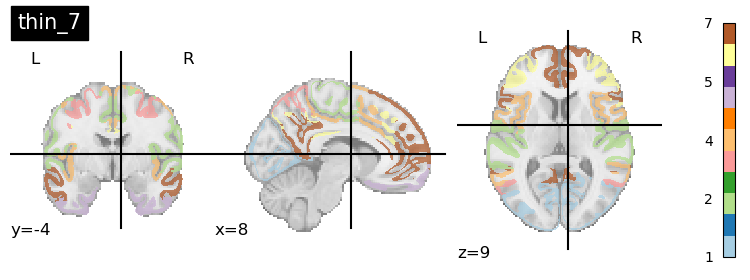

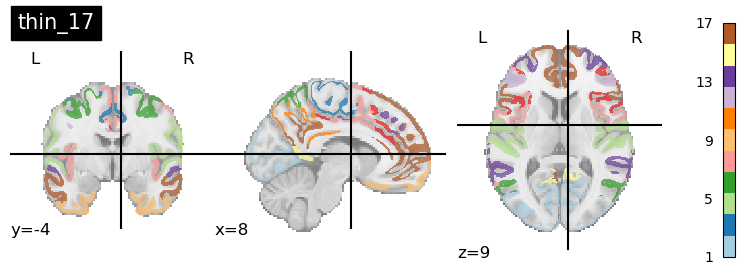

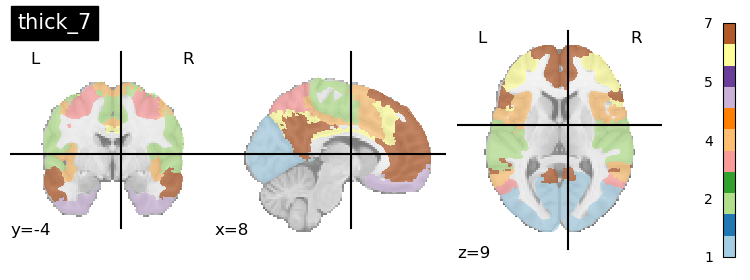

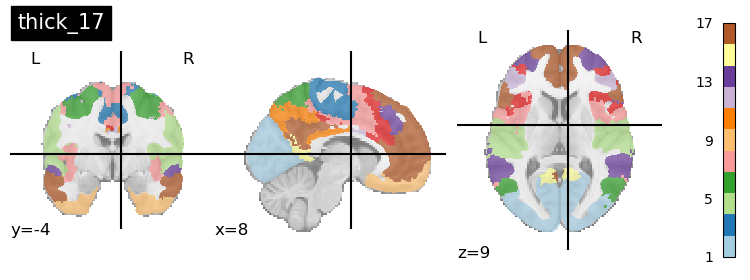

In [126]:
# checking Yeo Atlas
#Define where to slice the image
cut_coords = (8, -4, 9)
#Show a colorbar
colorbar=True
#Color scheme to show when viewing image
cmap='Paired'

#Plot all parcellation schemas referred to by atlas_yeo_2011
nplot.plot_roi(atlas_yeo_2011['thin_7'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thin_7')
nplot.plot_roi(atlas_yeo_2011['thin_17'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thin_17')
nplot.plot_roi(atlas_yeo_2011['thick_7'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thick_7')
nplot.plot_roi(atlas_yeo_2011['thick_17'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thick_17')

In [44]:
# get thick_7 atlas
atlas_yeo = atlas_yeo_2011['thick_7']

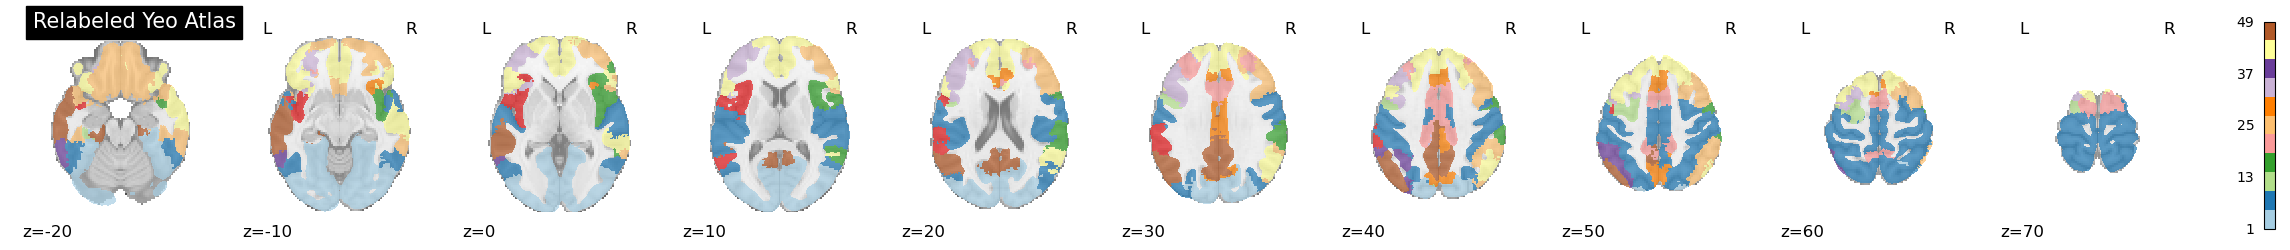

In [140]:
# Spatial Separation of Network
from nilearn.regions import connected_label_regions
region_labels = connected_label_regions(atlas_yeo)
nplot.plot_roi(region_labels, cut_coords=(-20,-10,0,10,20,30,40,50,60,70),
               display_mode='z',colorbar=True,cmap='Paired',
               title='Relabeled Yeo Atlas')

In [46]:
# Resampling the Atlas
# store the separated version of the atlas into a NIFTI file to work with it later
region_labels.to_filename('resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')

In [49]:
func_img = nib.load(func_file)

In [50]:
# Print dimensions of functional image and atlas image

print("Size of functional image:", func_img.shape)
print("Size of atlas image:", region_labels.shape)

resampled_yeo = nimg.resample_to_img(region_labels, func_img, interpolation = 'nearest')

Size of functional image: (68, 80, 65, 105)
Size of atlas image: (256, 256, 256)


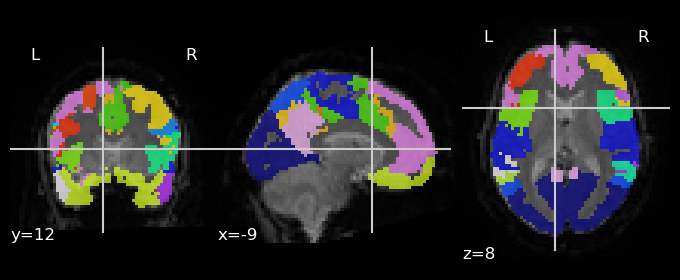

In [51]:
# what the resampled atlas looks like overlayed on a slice of our NifTI file
# Note that we're pulling a random timepoint from the fMRI data
nplot.plot_roi(resampled_yeo, func_img.slicer[:, :, :, 54])

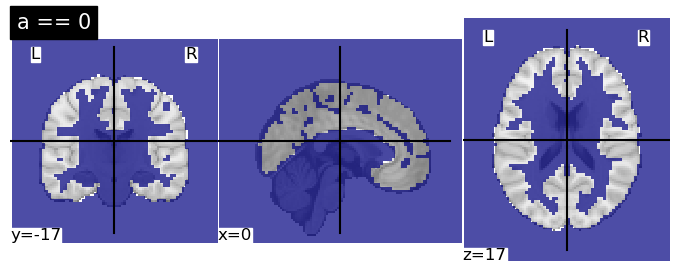

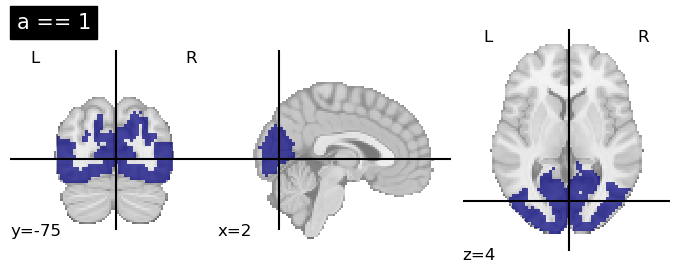

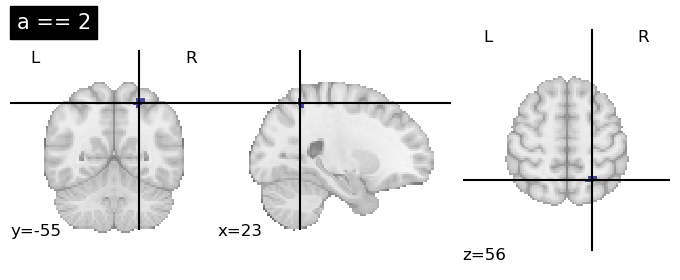

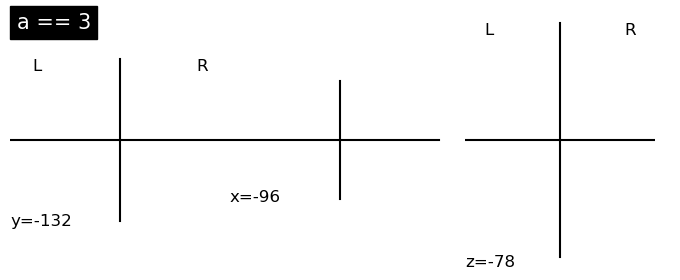

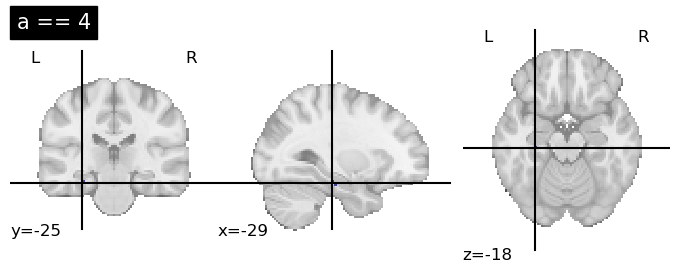

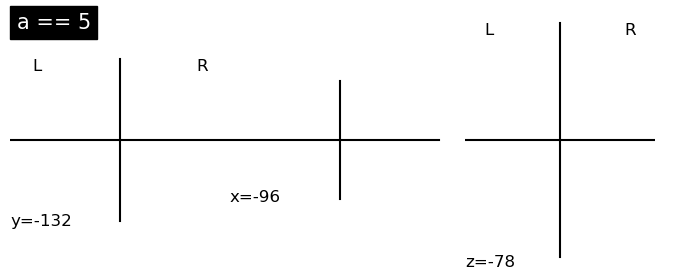

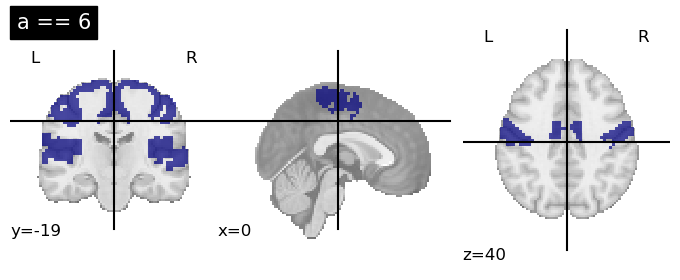

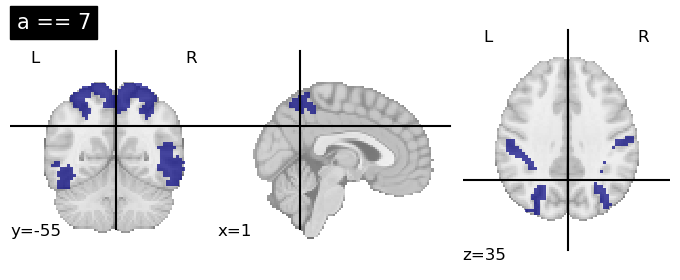

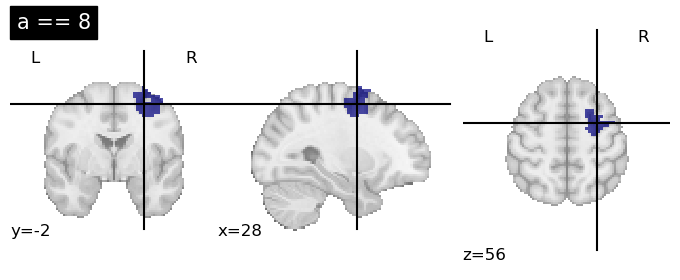

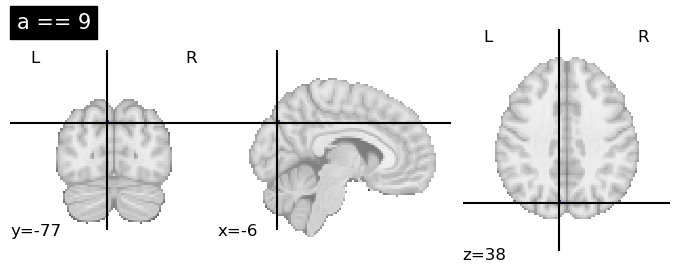

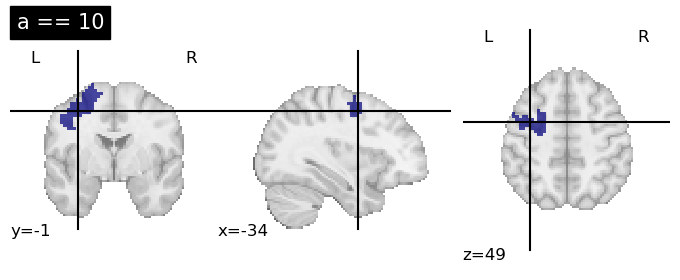

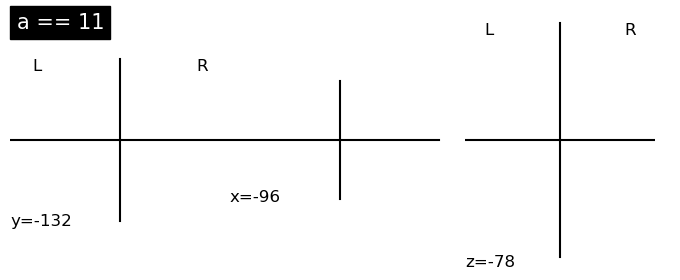

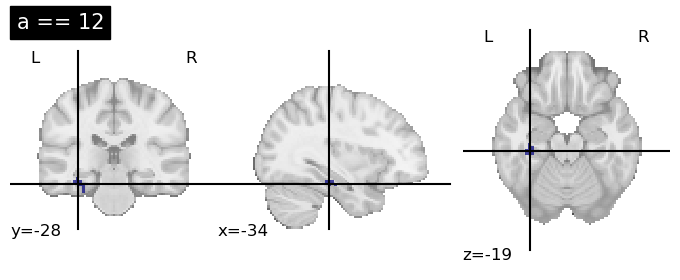

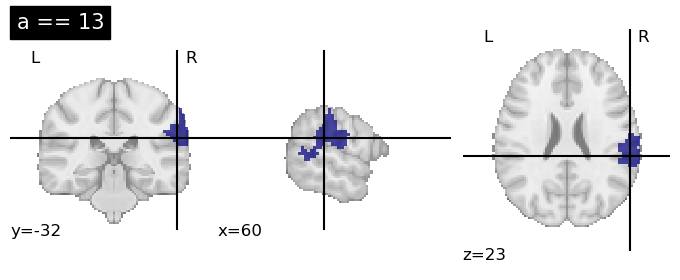

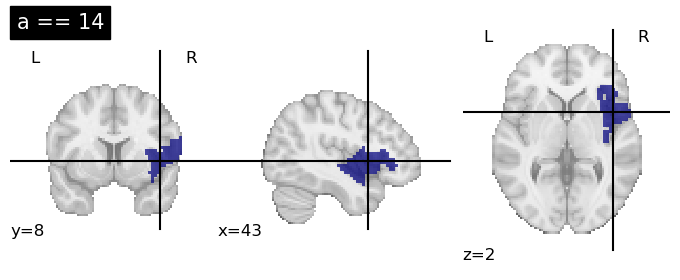

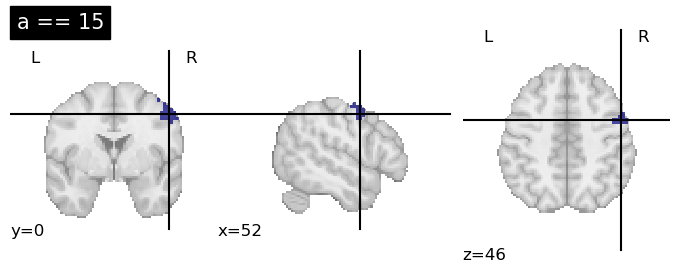

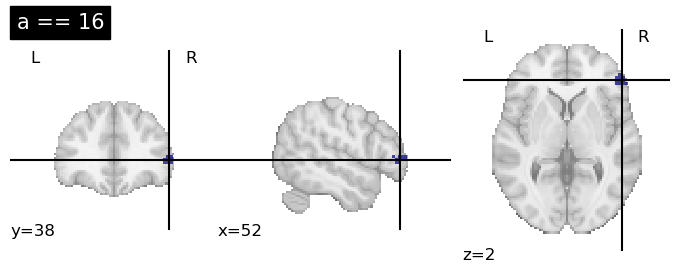

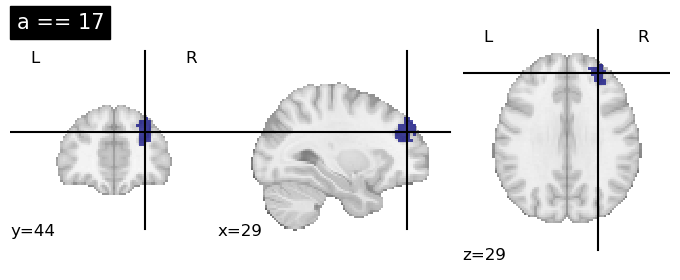

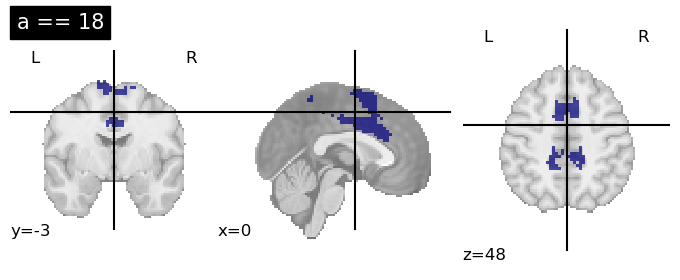

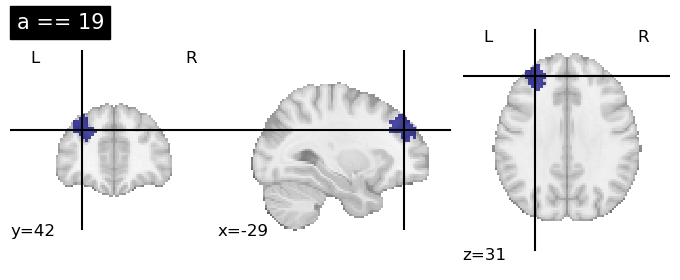

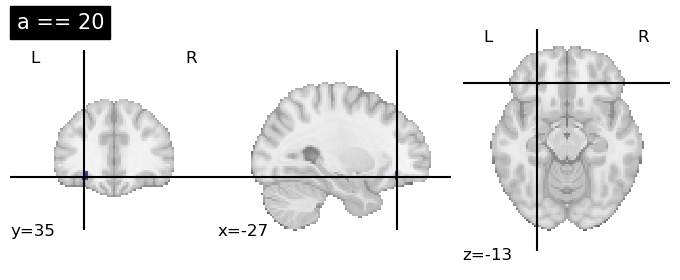

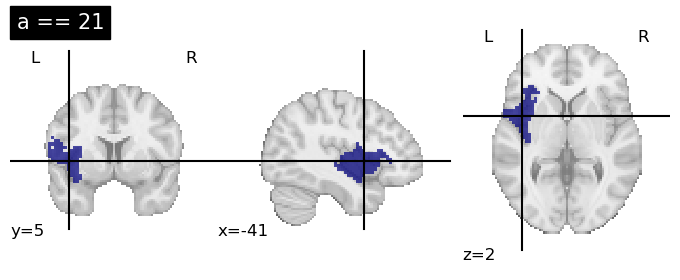

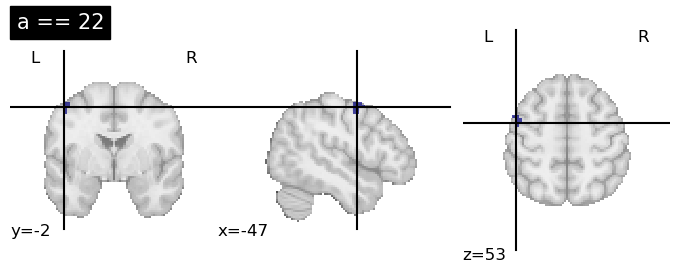

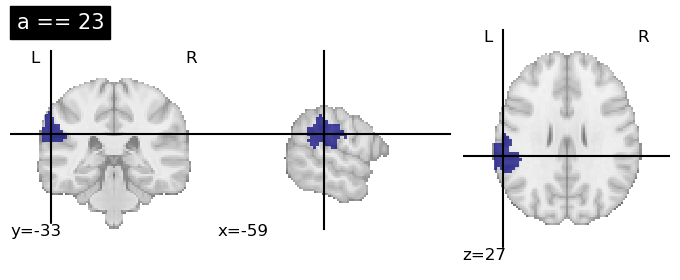

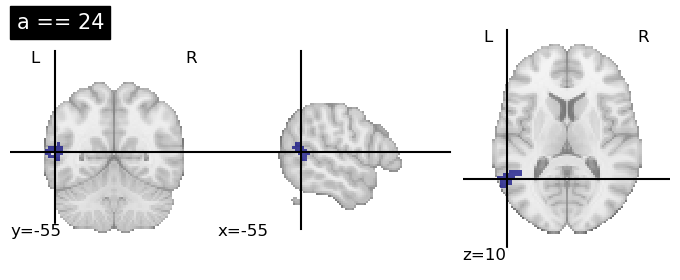

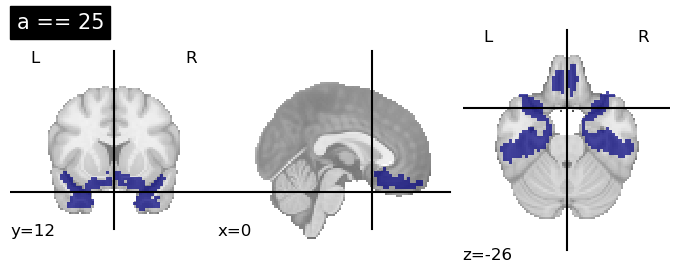

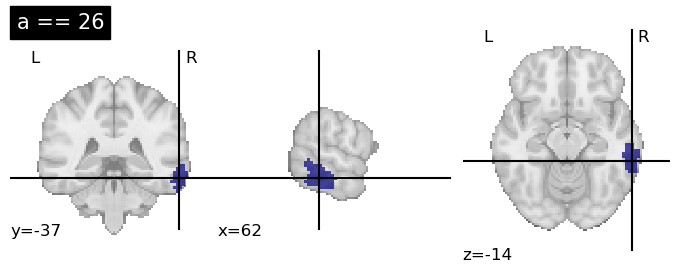

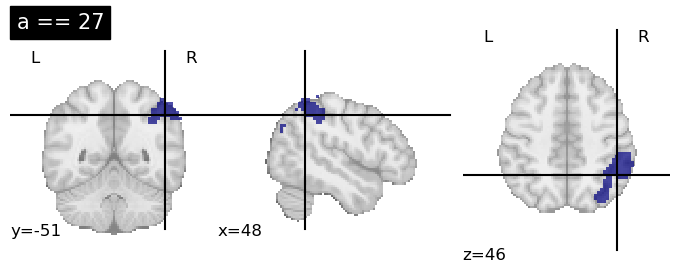

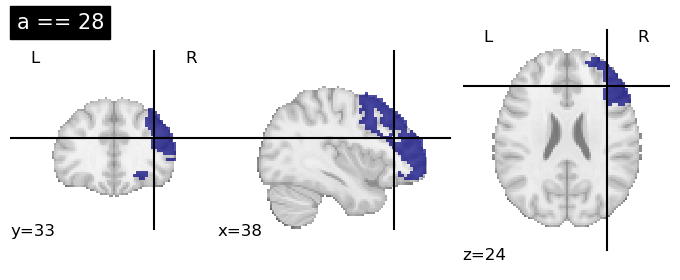

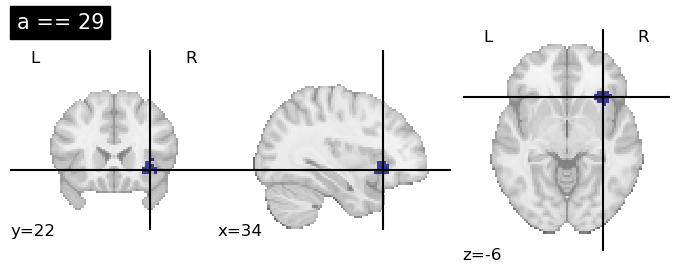

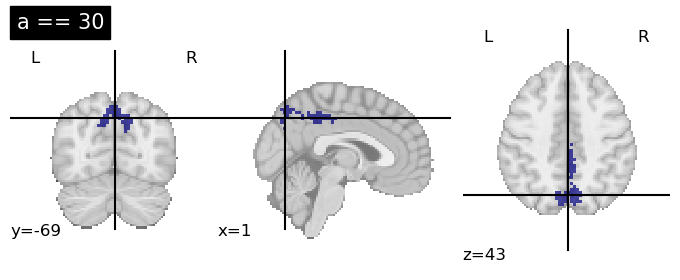

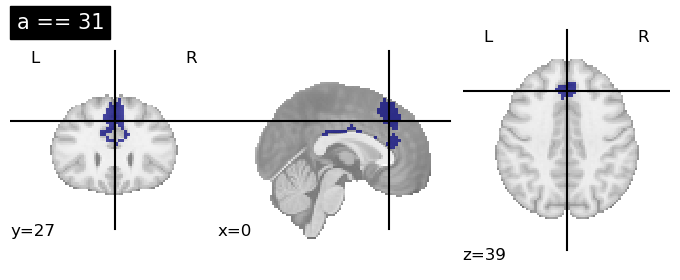

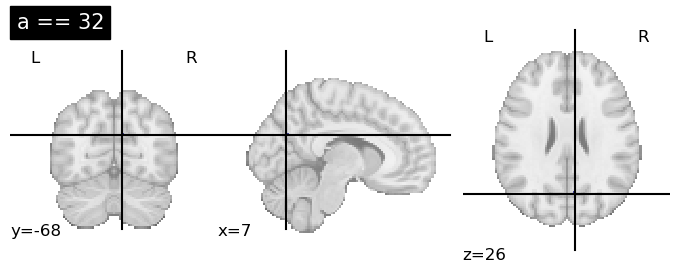

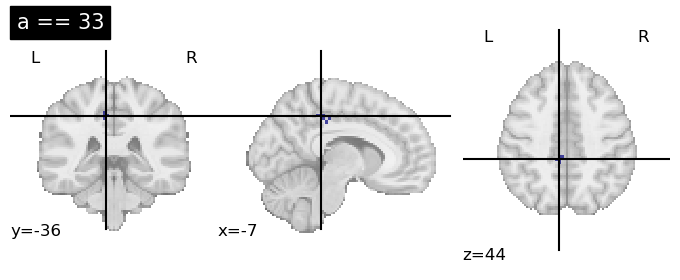

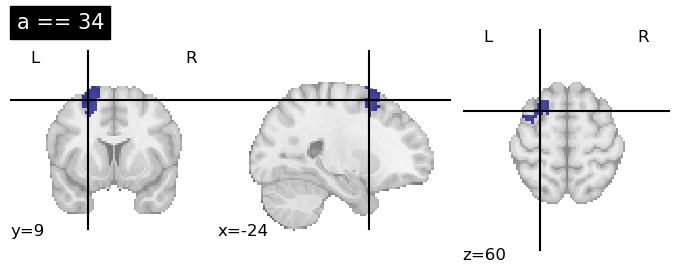

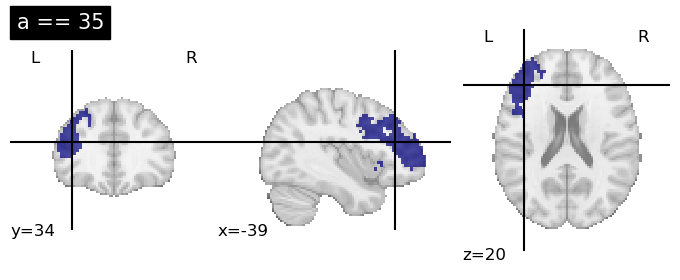

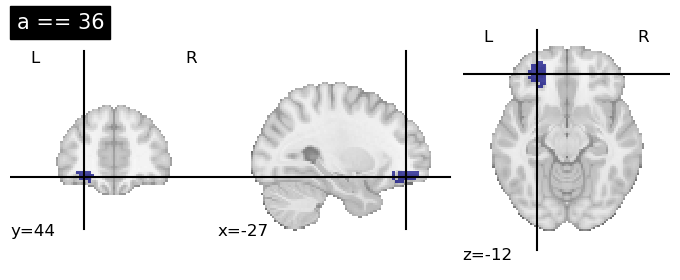

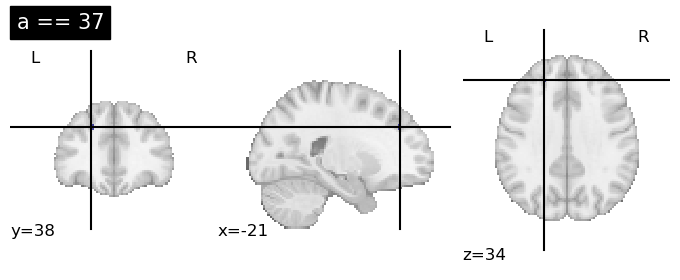

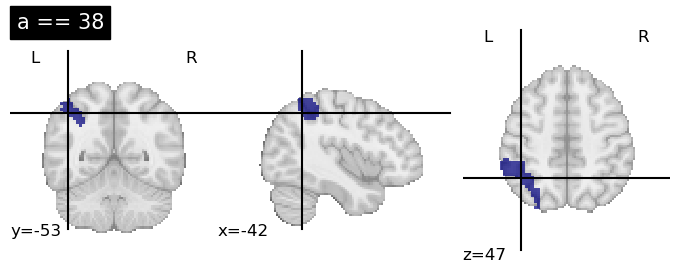

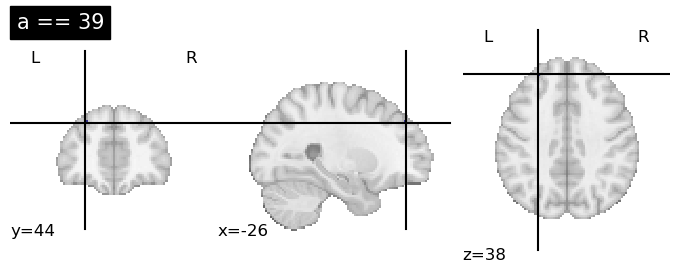

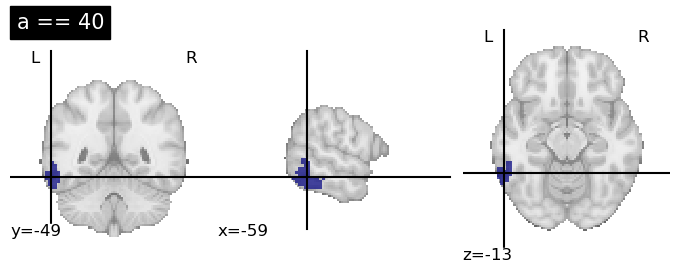

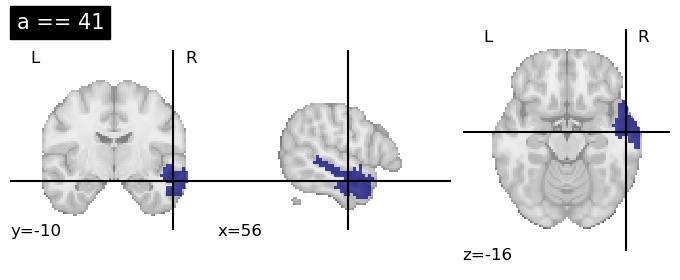

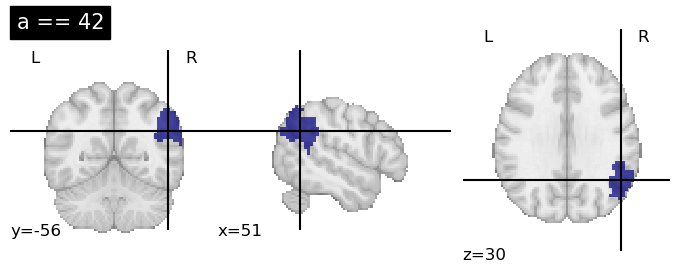

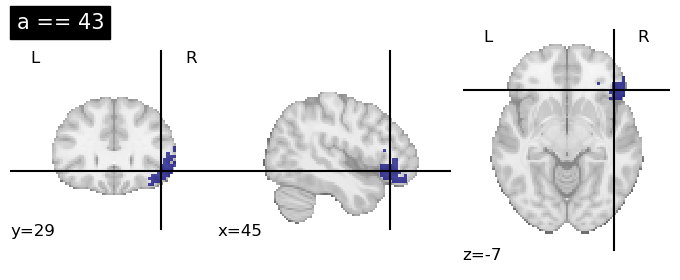

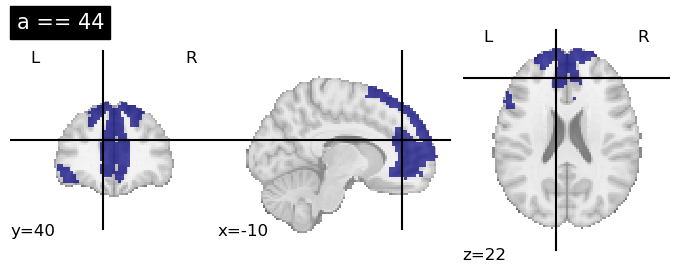

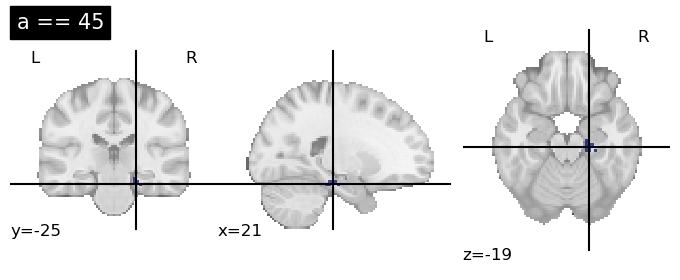

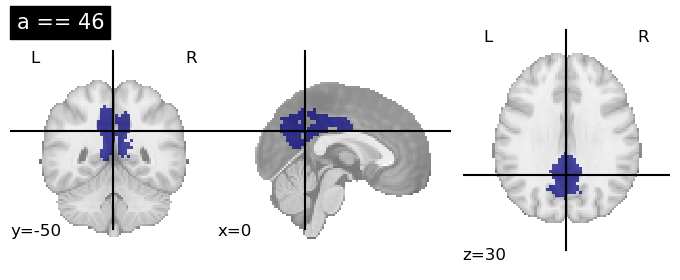

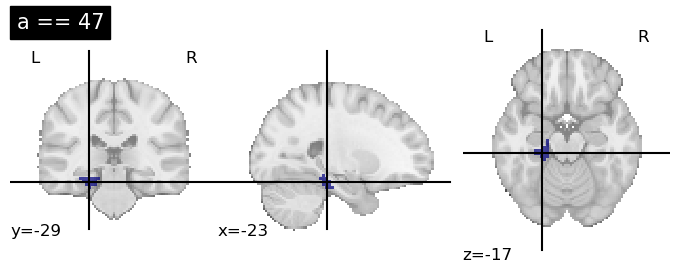

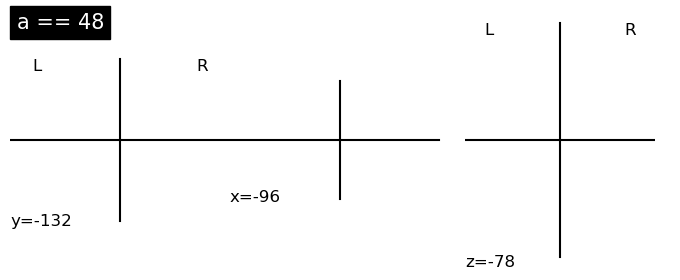

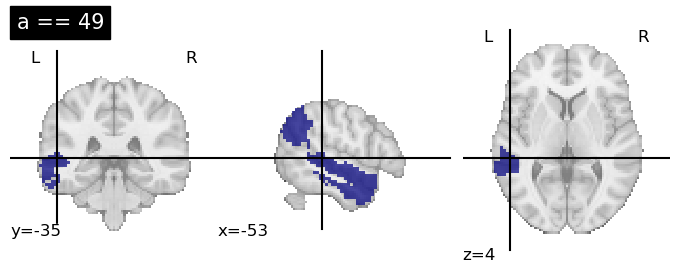

In [152]:
for i in range(50):
    a = "a == " + str(i)
    # print("ROI: " + a)
    # Make a mask for ROI
    roi_mask = nimg.math_img(a, a=resampled_yeo)  
    # Visualize ROI
    nplot.plot_roi(roi_mask, title = a)

# Functional Connectivity Analysis

In [350]:
# How can we estimate brain functional connectivity patterns from data?
from nilearn import image as nimg
from nilearn import plotting as nplot
import numpy as np
import pandas as pd
from bids import BIDSLayout

In [403]:
# Use PyBIDS to parse BIDS data structure
layout = BIDSLayout(fmriprep_dir, config=['bids','derivatives'])

In [404]:
# Get musical data (preprocessed, mask, and confounds file)
func_files = layout.get(subject=sub,
                        datatype='func', task='music',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                        return_type='file')

mask_files = layout.get(subject=sub,
                        datatype='func', task='music',
                        desc='brain',
                        suffix="mask",
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                        return_type='file')

confound_files = layout.get(subject=sub,
                            datatype='func',
                            task='music',
                            desc='confounds',
                            extension='tsv',
                            return_type='file')

In [405]:
#Load separated parcellation
parcel_file = 'resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz'
yeo_7 = nimg.load_img(parcel_file)

In [406]:
# import a package from nilearn, called input_data which allows us to pull data using the parcellation file,
# and at the same time applying data cleaning
from nilearn import input_data
masker = input_data.NiftiLabelsMasker(labels_img=yeo_7,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      verbose=1,
                                      detrend=True,
                                      low_pass = 0.08,
                                      high_pass = 0.009,
                                      t_r=3)

In [407]:
# Pull the first subject's data
func_file = func_files[0]
mask_file = mask_files[0]
confound_file = confound_files[0]

In [408]:
# Make confounds matrix
def extract_confounds(confound_tsv, confounds, dt=True):
    '''
    Arguments:
        confound_tsv    Full path to confounds.tsv
        confounds       A list of confounder variables to extract
        dt              Compute temporal derivatives [default = True]
        
    Outputs:
        confound_mat                    
    '''
    
    if dt:    
        dt_names = ['{}_derivative1'.format(c) for c in confounds]
        confounds = confounds + dt_names
    
    #Load in data using Pandas then extract relevant columns
    confound_df = pd.read_csv(confound_tsv,delimiter='\t') 
    confound_df = confound_df[confounds]
    
 
    #Convert into a matrix of values (timepoints)x(variable)
    confound_mat = confound_df.values 
    
    #Return confound matrix
    return confound_mat

In [409]:
# Drop Dummy TRs that are to be excluded from our cleaning, parcellation, and averaging step
# Load functional image
tr_drop = 4
func_img = nimg.load_img(func_file)

# Remove the first 4 TRs
func_img = func_img.slicer[:,:,:,tr_drop:]

# Use the above function to pull out a confound matrix
confounds = extract_confounds(confound_file,
                              ['trans_x','trans_y','trans_z',
                               'rot_x','rot_y','rot_z',
                               'global_signal',
                               'white_matter','csf'])
# Drop the first 4 rows of the confounds matrix
confounds = confounds[tr_drop:,:] 

In [410]:
# Using the masker, apply cleaning, parcellation and extraction to functional data
cleaned_and_averaged_time_series = masker.fit_transform(func_img, confounds)
cleaned_and_averaged_time_series.shape

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
Resampling labels


(101, 45)

In [411]:
# check which ROIs are kept
print(masker.labels_)
print("Number of labels", len(masker.labels_))

[1, 2, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49]
Number of labels 45


In [412]:
# fills in the regions that were removed with 0 values (for ease of use when working with multiple subjects)
# first, identify all ROIs from the original atlas
# Get the label numbers from the atlas
atlas_labels = np.unique(yeo_7.get_fdata().astype(int))

# Get number of labels that we have
NUM_LABELS = len(atlas_labels)
print(NUM_LABELS)

50


In [413]:
# Remember fMRI images are of size (x,y,z,t)
# where t is the number of timepoints
num_timepoints = func_img.shape[3]

# Create an array of zeros that has the correct size
final_signal = np.zeros((num_timepoints, NUM_LABELS))

# Get regions that are kept
regions_kept = np.array(masker.labels_)

# Fill columns matching labels with signal values
final_signal[:, regions_kept] = cleaned_and_averaged_time_series

print(final_signal.shape)

(101, 50)


In [414]:
# keep track of regions that was not removed my masker 
valid_regions_signal = final_signal[:, regions_kept]
print(valid_regions_signal.shape)

(101, 45)


In [415]:
np.array_equal(
    valid_regions_signal,
    cleaned_and_averaged_time_series)

True

In [416]:
# Calculating Connectivity
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')

In [417]:
# calculate the full correlation matrix for our parcellated data
full_correlation_matrix = correlation_measure.fit_transform([final_signal])
full_correlation_matrix.shape

(1, 50, 50)

In [418]:
full_correlation_matrix[0, 43, 45]

0.4139353220429633

# Music

In [462]:
# now apply it to every subject
# First we're going to create some empty lists to store all our data in
pooled_subjects = []
ctrl_subjects = []
mdd_subjects = []

# Which confound variables should we use?
confound_variables = ['trans_x','trans_y','trans_z',
                               'rot_x','rot_y','rot_z',
                               'global_signal',
                               'white_matter','csf']
# get the list of subjects
subjects = layout.get_subjects()
for sub in subjects:

    #Get the functional file for the subject (MNI space)
    func_files = layout.get(subject=sub,
                           datatype='func', task='music',
                           desc='preproc',
                           extension="nii.gz",
                           return_type='file')
    
    #Get the confounds file for the subject (MNI space)
    confound_files = layout.get(subject=sub, datatype='func',
                             task='music',
                             desc='confounds',
                             extension='tsv',
                             return_type='file')
    
    for i in range(len(func_files)):
        #Load the functional file in
        func_img = nimg.load_img(func_files[i])
    
        #Drop the first 4 TRs
        func_img = func_img.slicer[:,:,:,tr_drop:]
    
        #Extract the confound variables using the function
        confounds = extract_confounds(confound_files[i],
                                      confound_variables)
    
        #Drop the first 4 rows from the confound matrix
        #Which rows and columns should we keep?
        confounds = confounds[tr_drop:,:]
    
        #Apply the parcellation + cleaning to our data
        #What function of masker is used to clean and average data?
        time_series = masker.fit_transform(func_img, confounds)
    
        # fill the drop ROIs
        # Remember fMRI images are of size (x,y,z,t)
        # where t is the number of timepoints
        num_timepoints = func_img.shape[3]

        # Create an array of zeros that has the correct size
        final_signal = np.zeros((num_timepoints, NUM_LABELS))

        # Get regions that are kept
        regions_kept = np.array(masker.labels_)

        # Fill columns matching labels with signal values
        final_signal[:, regions_kept] = time_series
    
        #This collects a list of all subjects
        pooled_subjects.append(final_signal)
    
        #If the subject ID starts with a "control" then they are control
        if sub.startswith('control'):
            ctrl_subjects.append(final_signal)
        #If the subject ID starts with a "mdd" then they are mdd
        if sub.startswith('mdd'):
            mdd_subjects.append(final_signal)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_

In [463]:
# calculate the full correlation matrix for all data (correlation_measure works on the list as well)
ctrl_correlation_matrices = correlation_measure.fit_transform(ctrl_subjects)
mdd_correlation_matrices = correlation_measure.fit_transform(mdd_subjects)

## Visualizing Correlation Matrices and Group Differences

In [464]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

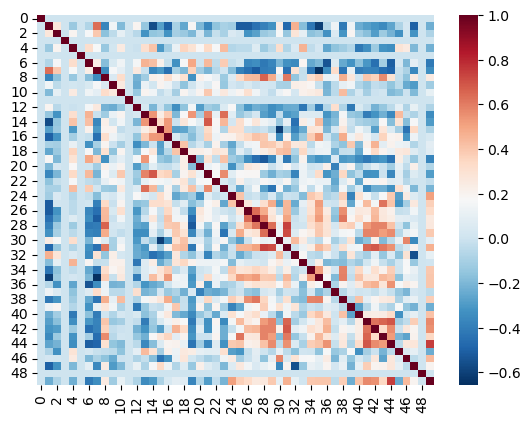

In [465]:
sns.heatmap(ctrl_correlation_matrices[0], cmap='RdBu_r')

Text(0.5, 1.0, 'Correlation Matrix for ND group, Music Task')

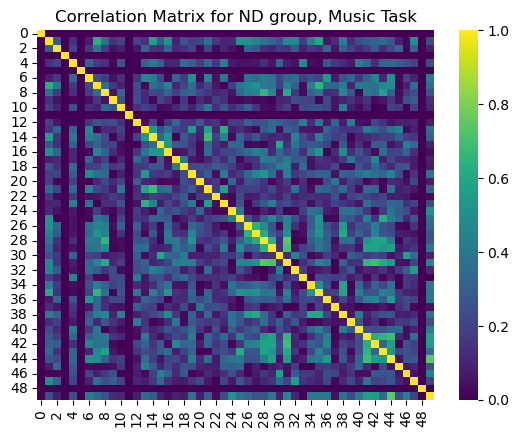

In [466]:
sns.heatmap(np.abs(ctrl_correlation_matrices[0]), cmap='viridis').set_title('Correlation Matrix for ND group, Music Task')

Text(0.5, 1.0, 'Correlation Matrix for MDD group, Music Task')

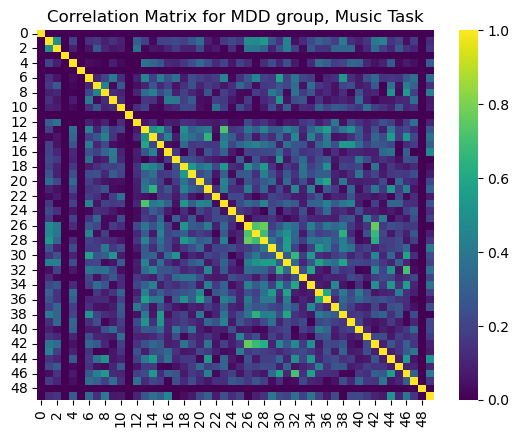

In [467]:
sns.heatmap(np.abs(mdd_correlation_matrices[0]), cmap='viridis').set_title('Correlation Matrix for MDD group, Music Task')

In [468]:
print(ctrl_correlation_matrices.shape)

(6, 50, 50)


In [469]:
# pull out just the correlation values between ROI 44 and 41 across all our subjects
ctrl_roi_vec = ctrl_correlation_matrices[:,44,41]
mdd_roi_vec = mdd_correlation_matrices[:,44,41]

In [470]:
# arrange this data into a table
#Create control dataframe
ctrl_df = pd.DataFrame(data={'AC_ACC_corr':ctrl_roi_vec, 'group':'control'})
ctrl_df.head()

AC_ACC_corr    group
0     0.692324  control
1     0.499350  control
2     0.421852  control
3     0.636363  control
4     0.448103  control

In [471]:
# Create the mdd dataframe
mdd_df = pd.DataFrame(data={'AC_ACC_corr':mdd_roi_vec, 'group' : 'mdd'})
mdd_df.head()

AC_ACC_corr group
0    -0.068150   mdd
1     0.369329   mdd
2     0.305971   mdd
3     0.294117   mdd
4     0.398849   mdd

In [472]:
# For visualization stack the two tables together
#Stack the two dataframes together
df_music = pd.concat([ctrl_df,mdd_df], ignore_index=True)

# Show some random samples from dataframe
# df.sample(n=7)

df_music

AC_ACC_corr    group
0      0.692324  control
1      0.499350  control
2      0.421852  control
3      0.636363  control
4      0.448103  control
5      0.299380  control
6     -0.068150      mdd
7      0.369329      mdd
8      0.305971      mdd
9      0.294117      mdd
10     0.398849      mdd
11     0.045207      mdd

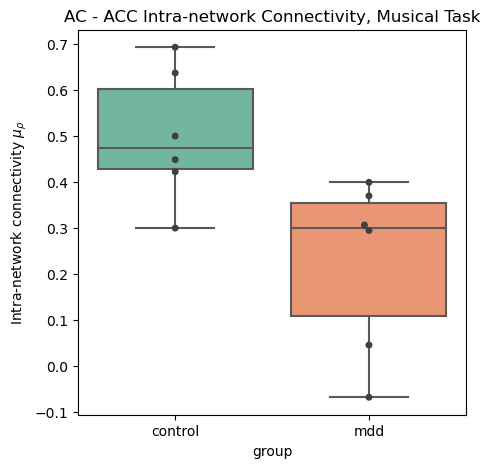

In [473]:
# Visualize results

# Create a figure canvas of equal width and height
plot = plt.figure(figsize=(5,5))
                  
# Create a box plot, with the x-axis as group
# the y-axis as the correlation value
ax = sns.boxplot(x='group',y='AC_ACC_corr',data=df_music,palette='Set2')

# Create a "swarmplot" as well
ax = sns.swarmplot(x='group',y='AC_ACC_corr',data=df_music,color='0.25')

# Set the title and labels of the figure
ax.set_title('AC - ACC Intra-network Connectivity, Musical Task')
ax.set_ylabel(r'Intra-network connectivity $\mu_\rho$')

plt.show()

In [474]:
# pull out just the correlation values between ROI 44 and 49 across all our subjects
ctrl_roi_vec = ctrl_correlation_matrices[:,44,49]
mdd_roi_vec = mdd_correlation_matrices[:,44,49]

In [475]:
# arrange this data into a table
#Create control dataframe
ctrl_df = pd.DataFrame(data={'AC_ACC_corr':ctrl_roi_vec, 'group':'control'})
ctrl_df.head()

AC_ACC_corr    group
0     0.745819  control
1     0.550316  control
2     0.676431  control
3     0.454386  control
4     0.400613  control

In [476]:
# Create the mdd dataframe
mdd_df = pd.DataFrame(data={'AC_ACC_corr':mdd_roi_vec, 'group' : 'mdd'})
mdd_df.head()

AC_ACC_corr group
0     0.512664   mdd
1     0.758968   mdd
2     0.516627   mdd
3     0.694276   mdd
4     0.707918   mdd

In [477]:
# For visualization stack the two tables together
#Stack the two dataframes together
df_music = pd.concat([ctrl_df,mdd_df], ignore_index=True)

# Show some random samples from dataframe
# df.sample(n=7)

df_music

AC_ACC_corr    group
0      0.745819  control
1      0.550316  control
2      0.676431  control
3      0.454386  control
4      0.400613  control
5      0.589507  control
6      0.512664      mdd
7      0.758968      mdd
8      0.516627      mdd
9      0.694276      mdd
10     0.707918      mdd
11     0.770246      mdd

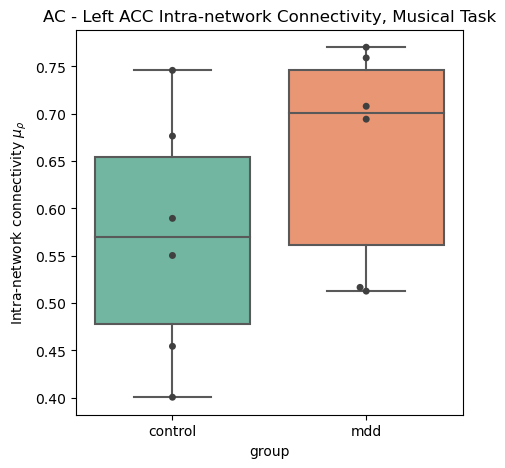

In [478]:
# Visualize results

# Create a figure canvas of equal width and height
plot = plt.figure(figsize=(5,5))
                  
# Create a box plot, with the x-axis as group
# the y-axis as the correlation value
ax = sns.boxplot(x='group',y='AC_ACC_corr',data=df_music,palette='Set2')

# Create a "swarmplot" as well
ax = sns.swarmplot(x='group',y='AC_ACC_corr',data=df_music,color='0.25')

# Set the title and labels of the figure
ax.set_title('AC - Left ACC Intra-network Connectivity, Musical Task')
ax.set_ylabel(r'Intra-network connectivity $\mu_\rho$')

plt.show()

# Non-Music

In [436]:
# now apply it to every subject for non-musical task
# First we're going to create some empty lists to store all our data in
pooled_subjects = []
ctrl_subjects = []
mdd_subjects = []

# Which confound variables should we use?
confound_variables = ['trans_x','trans_y','trans_z',
                               'rot_x','rot_y','rot_z',
                               'global_signal',
                               'white_matter','csf']
# get the list of subjects
subjects = layout.get_subjects()
for sub in subjects:

    #Get the functional file for the subject (MNI space)
    func_files = layout.get(subject=sub,
                           datatype='func', task='nonmusic',
                           desc='preproc',
                           extension="nii.gz",
                           return_type='file')
    
    #Get the confounds file for the subject (MNI space)
    confound_files = layout.get(subject=sub, datatype='func',
                             task='nonmusic',
                             desc='confounds',
                             extension='tsv',
                             return_type='file')
    
    for i in range(len(func_files)):
        #Load the functional file in
        func_img = nimg.load_img(func_files[i])
    
        #Drop the first 4 TRs
        func_img = func_img.slicer[:,:,:,tr_drop:]
    
        #Extract the confound variables using the function
        confounds = extract_confounds(confound_files[i],
                                      confound_variables)
    
        #Drop the first 4 rows from the confound matrix
        #Which rows and columns should we keep?
        confounds = confounds[tr_drop:,:]
    
        #Apply the parcellation + cleaning to our data
        #What function of masker is used to clean and average data?
        time_series = masker.fit_transform(func_img, confounds)
    
        # fill the drop ROIs
        # Remember fMRI images are of size (x,y,z,t)
        # where t is the number of timepoints
        num_timepoints = func_img.shape[3]

        # Create an array of zeros that has the correct size
        final_signal = np.zeros((num_timepoints, NUM_LABELS))

        # Get regions that are kept
        regions_kept = np.array(masker.labels_)

        # Fill columns matching labels with signal values
        final_signal[:, regions_kept] = time_series
    
        #This collects a list of all subjects
        pooled_subjects.append(final_signal)
    
        #If the subject ID starts with a "control" then they are control
        if sub.startswith('control'):
            ctrl_subjects.append(final_signal)
        #If the subject ID starts with a "mdd" then they are mdd
        if sub.startswith('mdd'):
            mdd_subjects.append(final_signal)

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_atlas.nii.gz')
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('resources\rois\yeo_2011\Yeo_JNeurophysiol11_MNI152\relabeled_yeo_

In [437]:
# calculate the full correlation matrix for all data (correlation_measure works on the list as well)
ctrl_correlation_matrices = correlation_measure.fit_transform(ctrl_subjects)
mdd_correlation_matrices = correlation_measure.fit_transform(mdd_subjects)

## Visualizing Correlation Matrices and Group Differences

In [438]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

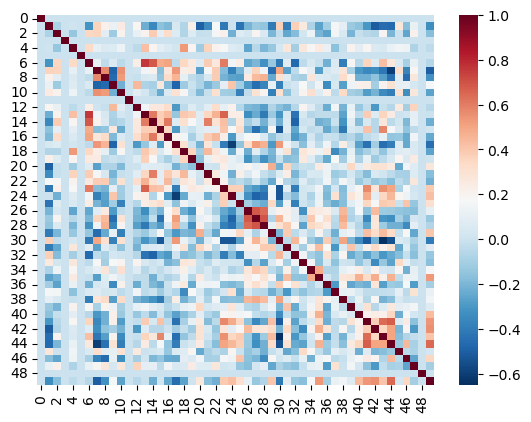

In [439]:
sns.heatmap(ctrl_correlation_matrices[0], cmap='RdBu_r')

Text(0.5, 1.0, 'Correlation Matrix for ND group, Non-Music Task')

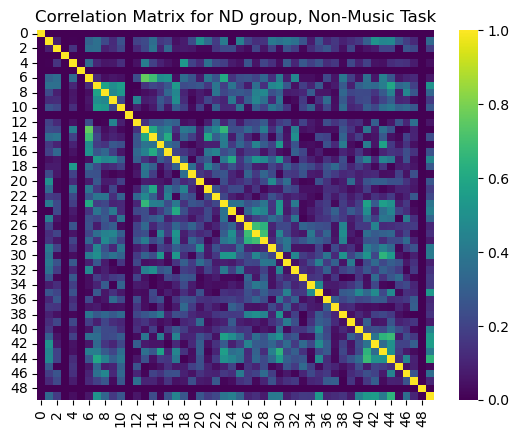

In [440]:
sns.heatmap(np.abs(ctrl_correlation_matrices[0]), cmap='viridis').set_title('Correlation Matrix for ND group, Non-Music Task')

Text(0.5, 1.0, 'Correlation Matrix for MDD group, Non-Music Task')

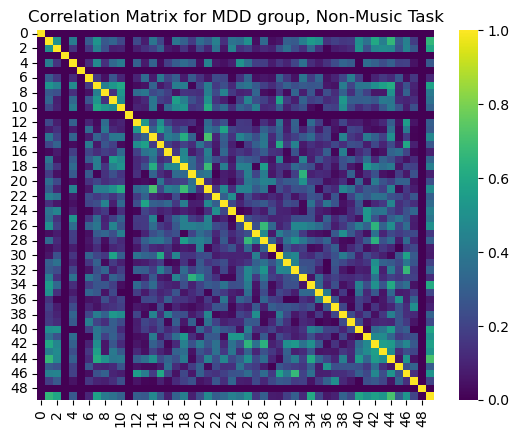

In [441]:
sns.heatmap(np.abs(mdd_correlation_matrices[0]), cmap='viridis').set_title('Correlation Matrix for MDD group, Non-Music Task')

In [442]:
print(ctrl_correlation_matrices.shape)

(4, 50, 50)


In [443]:
# pull out just the correlation values between ROI 44 and 41 across all our subjects
ctrl_roi_vec = ctrl_correlation_matrices[:,44,41]
mdd_roi_vec = mdd_correlation_matrices[:,44,41]

In [444]:
# arrange this data into a table
#Create control dataframe
ctrl_df = pd.DataFrame(data={'AC_ACC_corr':ctrl_roi_vec, 'group':'control'})
ctrl_df.head()

AC_ACC_corr    group
0     0.676406  control
1     0.591649  control
2     0.331425  control
3     0.518895  control

In [445]:
# Create the mdd dataframe
mdd_df = pd.DataFrame(data={'AC_ACC_corr':mdd_roi_vec, 'group' : 'mdd'})
mdd_df.head()

AC_ACC_corr group
0     0.320510   mdd
1     0.112568   mdd
2     0.172342   mdd
3     0.496927   mdd

In [446]:
# For visualization stack the two tables together
#Stack the two dataframes together
df_nonmusic = pd.concat([ctrl_df,mdd_df], ignore_index=True)

# Show some random samples from dataframe
# df.sample(n=7)

df_nonmusic

AC_ACC_corr    group
0     0.676406  control
1     0.591649  control
2     0.331425  control
3     0.518895  control
4     0.320510      mdd
5     0.112568      mdd
6     0.172342      mdd
7     0.496927      mdd

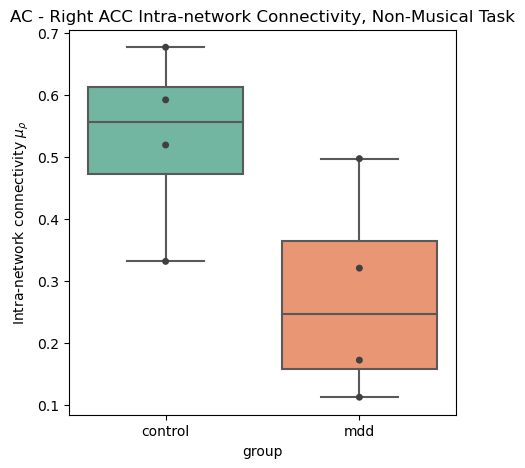

In [447]:
# Visualize results

# Create a figure canvas of equal width and height
plot = plt.figure(figsize=(5,5))
                  
# Create a box plot, with the x-axis as group
# the y-axis as the correlation value
ax = sns.boxplot(x='group',y='AC_ACC_corr',data=df_nonmusic,palette='Set2')

# Create a "swarmplot" as well
ax = sns.swarmplot(x='group',y='AC_ACC_corr',data=df_nonmusic,color='0.25')

# Set the title and labels of the figure
ax.set_title('AC - Right ACC Intra-network Connectivity, Non-Musical Task')
ax.set_ylabel(r'Intra-network connectivity $\mu_\rho$')

plt.show()

In [448]:
# pull out just the correlation values between ROI 44 and 49 across all our subjects
ctrl_roi_vec = ctrl_correlation_matrices[:,44,49]
mdd_roi_vec = mdd_correlation_matrices[:,44,49]

In [449]:
# arrange this data into a table
#Create control dataframe
ctrl_df = pd.DataFrame(data={'AC_ACC_corr':ctrl_roi_vec, 'group':'control'})
ctrl_df.head()

AC_ACC_corr    group
0     0.647581  control
1     0.672488  control
2     0.367679  control
3     0.469284  control

In [450]:
# Create the mdd dataframe
mdd_df = pd.DataFrame(data={'AC_ACC_corr':mdd_roi_vec, 'group' : 'mdd'})
mdd_df.head()

AC_ACC_corr group
0     0.708775   mdd
1     0.448094   mdd
2     0.691701   mdd
3     0.576144   mdd

In [451]:
# For visualization stack the two tables together
#Stack the two dataframes together
df_music = pd.concat([ctrl_df,mdd_df], ignore_index=True)

# Show some random samples from dataframe
# df.sample(n=7)

df_music

AC_ACC_corr    group
0     0.647581  control
1     0.672488  control
2     0.367679  control
3     0.469284  control
4     0.708775      mdd
5     0.448094      mdd
6     0.691701      mdd
7     0.576144      mdd

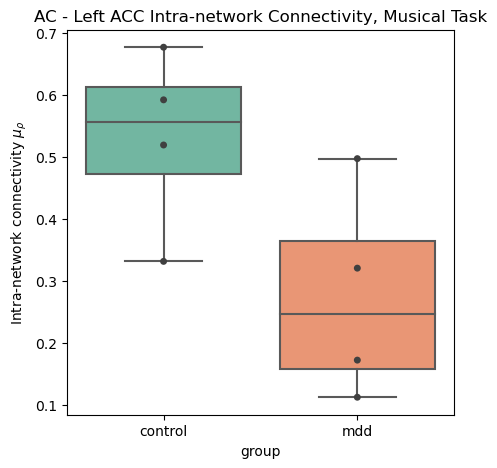

In [452]:
# Visualize results

# Create a figure canvas of equal width and height
plot = plt.figure(figsize=(5,5))
                  
# Create a box plot, with the x-axis as group
# the y-axis as the correlation value
ax = sns.boxplot(x='group',y='AC_ACC_corr',data=df_nonmusic,palette='Set2')

# Create a "swarmplot" as well
ax = sns.swarmplot(x='group',y='AC_ACC_corr',data=df_nonmusic,color='0.25')

# Set the title and labels of the figure
ax.set_title('AC - Left ACC Intra-network Connectivity, Musical Task')
ax.set_ylabel(r'Intra-network connectivity $\mu_\rho$')

plt.show()

In [401]:
from nilearn import plotting
coords = plotting.find_parcellation_cut_coords(yeo_7)

In [402]:
coords = np.append(coords, [[0, 0, 0]], axis = 0) # to match the dimension of the matrix 

In [338]:
coords.shape

(50, 3)

In [339]:
coords

array([[-22.26254905, -77.77055908,   3.67973072],
       [ 24.27819549, -55.81203008,  57.0112782 ],
       [-14.        , -34.        ,  -4.        ],
       [-30.91803279, -23.72131148, -21.21311475],
       [-34.66666667, -24.22222222, -18.55555556],
       [-36.61613048, -21.41024624,  40.9779725 ],
       [-35.23847176, -56.43335729,  32.62734976],
       [ 37.00391294,   2.00497269,  44.26371566],
       [ -5.7       , -78.5       ,  39.3       ],
       [-33.93000904,  -0.87505134,  49.32588516],
       [-26.81818182, -32.45454545, -20.18181818],
       [-33.79573171, -27.75914634, -20.81402439],
       [ 60.40585774, -32.8252056 ,  23.5296494 ],
       [ 43.63453261,   8.79599382,   1.43665158],
       [ 52.13052012,   0.67419038,  46.31501472],
       [ 52.37285491,  39.00936037,   1.98439938],
       [ 30.01151742,  44.88252232,  29.23869853],
       [ -7.96571281,  -6.81934777,  47.49587523],
       [-29.63331371,  41.8120463 ,  31.32313125],
       [-26.05511811,  35.94488

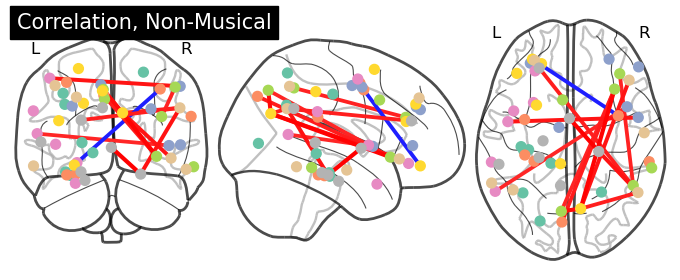

In [485]:
plotting.plot_connectome(ctrl_correlation_matrices[0], coords,
                         edge_threshold="99%", title='Correlation, Non-Musical')

In [341]:
view = plotting.view_connectome(ctrl_correlation_matrices[0], coords,
                               edge_threshold="95%", title='Correlation, Non-Musical')
# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view

In [484]:
func_files[0]

'C:\\Users\\nasri\\OneDrive - University of Oklahoma\\Nasri\\Neural Data Science\\Neural Data Science Project\\Dataset\\dataset\\derivatives\\sub-control01\\func\\sub-control01_task-music_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'